# Audio Classification 

### Drive Mount and Importing the Libtraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pkgs loading
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset and Metadata

In [3]:
audio_dataset_path='/content/drive/MyDrive/Capstone/UrbanSound8K/audio'
metadata=pd.read_csv('/content/drive/MyDrive/Capstone/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
# Dataset Balancing/Imbalancing Check
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

### EDA

In [5]:
dat1, sampling_rate1 = librosa.load('/content/drive/MyDrive/Capstone/UrbanSound8K/audio/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('/content/drive/MyDrive/Capstone/UrbanSound8K/audio/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

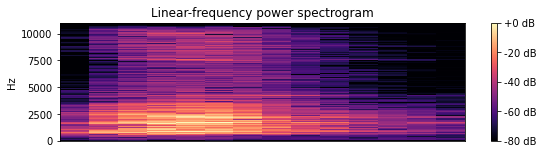

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

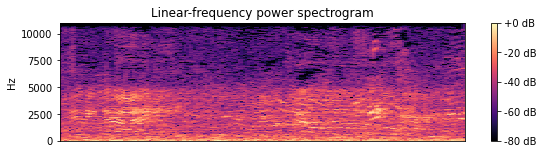

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

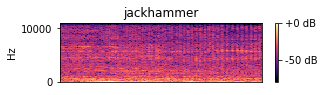

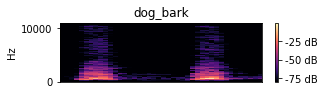

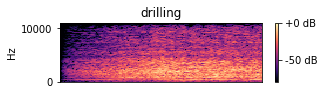

In [8]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(metadata["slice_file_name"])
fold = np.array(metadata["fold"])
cla = np.array(metadata["class"])

for i in range(192, 197, 2):
    path = '/content/drive/MyDrive/Capstone/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

### Features Extraction

In [9]:
# Extracting MFCC's For every audio file
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, sr=None, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [10]:
# Features extraction from all audio files (MFCC)
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

2850it [31:53,  1.65it/s]/usr/local/lib/python3.9/dist-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
8732it [1:36:55,  1.50it/s]


In [11]:
# Converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-275.91843, 119.4928, -98.21178, -66.51513, -...",dog_bark
1,"[-500.9084, 185.10641, -86.53282, 49.85885, 9....",children_playing
2,"[-531.1953, 186.93994, -70.34916, 40.429245, 9...",children_playing
3,"[-476.78442, 160.33328, -62.952843, 50.75117, ...",children_playing
4,"[-521.2447, 185.39265, -81.95048, 46.47355, 11...",children_playing


In [12]:
# Data Frame Saving
extracted_features_df.to_csv("UrbanSound8K_DF.csv")

### Data Splitting and Encoding

In [13]:
# Data Splitting
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape

(8732, 40)

In [15]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [16]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [17]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Training Testing Sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
X_train

array([[-1.8378271e+02,  1.5365129e+02, -3.6178783e+01, ...,
         1.0025054e+00, -4.7213894e-01, -1.2038720e+00],
       [-8.4152161e+01,  1.6649818e+02, -6.1209232e+01, ...,
        -4.0521545e+00, -3.3977334e+00, -8.2560587e+00],
       [-6.7970741e+01,  2.6627291e+01, -4.8024197e+01, ...,
        -4.1831975e+00,  2.3861418e+00,  4.4640236e+00],
       ...,
       [-4.7486859e+02,  9.3468300e+01,  3.2284161e+01, ...,
        -1.1071193e+00, -1.5656761e+00, -9.8130518e-01],
       [-2.0102074e+02,  1.7294638e+02, -3.5023716e+01, ...,
         4.1071025e-01, -1.1205076e+00,  4.3810743e-01],
       [-4.8265601e+02,  2.3059308e+02,  2.8331995e+01, ...,
         7.3604614e-01, -1.9397887e+00, -4.5186167e+00]], dtype=float32)

In [20]:
X_train.shape

(6985, 40)

In [21]:
X_test.shape

(1747, 40)

In [22]:
y_train.shape

(6985, 10)

In [23]:
y_test.shape

(1747, 10)

### Model Creation

In [24]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics

In [26]:
# No of classes
num_labels=y.shape[1]
print(num_labels)

10


In [27]:
model=Sequential()

#first layer
model.add(Dense(1600,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              65600     
                                                                 
 activation (Activation)     (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               1280800   
                                                                 
 activation_1 (Activation)   (None, 800)               0         
                                                                 
 dropout_1 (Dropout)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 400)               3

In [29]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [30]:
# Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

In [31]:
num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.h5', verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
54/55 [============================>.] - ETA: 0s - loss: 7.3513 - accuracy: 0.1549
Epoch 1: val_loss improved from inf to 2.19702, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 6s 88ms/step - loss: 7.3023 - accuracy: 0.1550 - val_loss: 2.1970 - val_accuracy: 0.2324
Epoch 2/100
54/55 [============================>.] - ETA: 0s - loss: 2.2224 - accuracy: 0.2141
Epoch 2: val_loss improved from 2.19702 to 2.10680, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 3s 58ms/step - loss: 2.2231 - accuracy: 0.2143 - val_loss: 2.1068 - val_accuracy: 0.2673
Epoch 3/100
54/55 [============================>.] - ETA: 0s - loss: 2.1317 - accuracy: 0.2323
Epoch 3: val_loss improved from 2.10680 to 2.01721, saving model to saved_models/audio_classification.h5
55/55 [==============================] - 3s 60ms/step - loss: 2.1316 - accuracy: 0.2322 - val_loss: 2.0172 - val_accuracy: 0.3268
Epoch 4/100
55

In [32]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9336004853248596


### Testing Some NEW Audio Data

In [33]:
filename="/content/drive/MyDrive/Capstone/UrbanSound8K/sample/mixkit-ambulance-siren-uk-1640.wav"
audio, sample_rate = librosa.load(filename, sr=None, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [34]:
mfccs_scaled_features.shape

(40,)

In [35]:
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print('Predicted Label:',predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class[0]

(1, 40)
1/1 [==============================] - 0s 172ms/step
Predicted Label: [8]


'siren'